# **Sprint 3: Baseline Model**
*******

## **1. Introduction**
- Briefly restate research questions.
- Purpose of baseline model → provide a benchmark for later models.
- Mention you will test three baselines: majority class, logistic regression, and decision tree.


## **2.Data Preparation**


Import cleaned dataset.
- Define target variable: `SexualAssault` (1 = sexual assault, 0 = other).
- Define predictors: demographics, neighborhood, prior incidents, etc.
- Train/test split.
—-
Code cell: Import your cleaned dataset.
Code cell: Define the target variable (SexualAssault) and predictors.
Code cell: Create a train/test split.



CODE SECTION HERE

Code cell: Import your cleaned dataset.
Code cell: Define the target variable (SexualAssault) and predictors.
Code cell: Create a train/test split.


In [16]:
# IMPORT CLEAN DATASET FROM PREVIOUS NOTEBOOK
# main code
import pandas as pd
import numpy as np

# Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_fscore_support
)

pd.set_option("display.max_columns", 120)

df = pd.read_csv('/Users/jennifersalinas/Desktop/GPT-Final-Boss---dtsc-3601-project/notebook/cleaned_dataset.csv')
print("shape:",df.shape)
df.head(3)

shape: (729458, 23)


,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LAT,LON,SexualAssault,DATE_OCC_dt,datetime_occurrence
0,211507896,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,354,THEFT OF IDENTITY,0377,31,M,H,501.0,SINGLE FAMILY DWELLING,NaN,Unknown,IC,Invest Cont,34.2124,-118.4092,0,2020-11-07,2020-11-07 08:45:00
1,201516622,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0416 0334 2004 1822 1414 0305 0319 0400,32,M,H,102.0,SIDEWALK,200.0,KNIFE WITH BLADE 6INCHES OR LESS,IC,Invest Cont,34.1993,-118.4203,0,2020-10-18,2020-10-18 18:45:00
2,240913563,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,354,THEFT OF IDENTITY,0377,30,M,W,501.0,SINGLE FAMILY DWELLING,NaN,Unknown,IC,Invest Cont,34.1847,-118.4509,0,2020-10-30,2020-10-30 12:40:00


In [17]:
#Code cell: Define the target variable (SexualAssault) and predictors.

#will list the columns so we can identify our target variable - SexualAssault
df.columns.tolist() 

#defines TARGET which was already made in the clean data notebook
TARGET = 'SexualAssault'

predictors = [
    # Demographics of vixims
    "Vict Age", "Vict Sex", "Vict Descent",
    #Location
    "AREA", "AREA NAME", "Rpt Dist No",
    # crime context
    "Premis Desc", "Weapon Desc",
    # time and date
    "datetime_occurrence" #this is the new column we made in the clean data notebook 
]

# Safety checks - make sure all columns are present
missing_cols = [c for c in predictors + [TARGET] if c not in df.columns]
if missing_cols:
    raise ValueError(f"These columns are missing from the file: {missing_cols}")

#this is were we set up our x and y
X = df[predictors].copy()
y = df[TARGET].copy()

print("Target variable:", TARGET)
print("============================")
print("X shape:", X.shape, "| y shape:", y.shape)
print("============================")
print("Predictors used:", X.columns.tolist())
print("============================")
y.value_counts(dropna=False)

X.dtypes




#y.value_counts(normalize=True).round(3)
#y.value_counts(normalize=True).rename("proportion").round(4)

Target variable: SexualAssault
X shape: (729458, 9) | y shape: (729458,)
Predictors used: ['Vict Age', 'Vict Sex', 'Vict Descent', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Premis Desc', 'Weapon Desc', 'datetime_occurrence']


Vict Age                int64
Vict Sex               object
Vict Descent           object
AREA                    int64
AREA NAME              object
Rpt Dist No             int64
Premis Desc            object
Weapon Desc            object
datetime_occurrence    object
dtype: object

In [18]:
#we converted the datetime_occurrence column to datetime

# Convert to datetime
X["datetime_occurrence"] = pd.to_datetime(X["datetime_occurrence"], errors="coerce")

# Extract features
X["occ_month"] = X["datetime_occurrence"].dt.month
X["occ_dow"]   = X["datetime_occurrence"].dt.dayofweek
X["occ_hour"]  = X["datetime_occurrence"].dt.hour

#create a time bin - this will help us determin the time of day the crime happened which could correlate to where crime happens the most
def time_bin(hour):
    if 5 <= hour < 12:   return "morning"
    elif 12 <= hour < 17: return "afternoon"
    elif 17 <= hour < 21: return "evening"
    else:                 return "night"

X["time_bin"] = X["occ_hour"].apply(time_bin)

# Drop raw datetime (since we extracted parts)
X = X.drop(columns=["datetime_occurrence"])

# this is what it looks like now, more cleaner than before
X[["occ_month", "occ_dow", "occ_hour", "time_bin"]].head()



,occ_month,occ_dow,occ_hour,time_bin
0,11,5,8,morning
1,10,6,18,evening
2,10,4,12,afternoon
3,12,3,13,afternoon
4,9,1,18,evening


In [19]:
#Code cell: Create a train/test split.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (
    X,y,
    test_size=0.3, #30% test set
    random_state=42,
    stratify=y
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes :", X_test.shape, y_test.shape)

print("\nClass balance in training set:")
print(y_train.value_counts(normalize=True).round(3))

print("\nClass balance in test set:")
print(y_test.value_counts(normalize=True).round(3))

#ABOUT THE OUTPUT :)
#Train = 510k rows, Test = 218k rows WHICH shows that our train/test split is now 70/30. 70 training, 30 test
#Class balance is preserved (0.987 / 0.013 in both sets) - Stratification worked

Train shapes: (510620, 12) (510620,)
Test shapes : (218838, 12) (218838,)

Class balance in training set:
SexualAssault
0    0.987
1    0.013
Name: proportion, dtype: float64

Class balance in test set:
SexualAssault
0    0.987
1    0.013
Name: proportion, dtype: float64


## **3. Baseline Models**


#### 3.1 MODEL ONE: Majority Class Model


In [28]:
#Code cell: Build and evaluate the majority class model.

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

majority_class = y_train.mode()[0] 
print("Majority class is:", majority_class)

y_pred_majority = np.full (
    shape=y_test.shape,
    fill_value=majority_class
)

print("==== BASELINE: Majority class model ===")
print("Accuracy:", accuracy_score(y_test, y_pred_majority))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_majority))
print(classification_report(y_test, y_pred_majority, zero_division=0))


# How many of each label in TRAIN?
y_train.value_counts()
y_train.value_counts(normalize=True).round(3)

# Quick sanity: baseline accuracy should equal the majority proportion
majority_prop = y_train.value_counts(normalize=True).max()
print("Expected majority accuracy ~", majority_prop)

'''
SAME OUTPUT AS ABOVE - WHICH ONE IS BETTER TO KEEP? - ASK OPTIONS
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("=== DummyClassifier (most_frequent) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy, zero_division=0))
'''

Majority class is: 0
==== BASELINE: Majority class model ===
Accuracy: 0.9871183249709831
Confusion matrix:
 [[216019      0]
 [  2819      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    216019
           1       0.00      0.00      0.00      2819

    accuracy                           0.99    218838
   macro avg       0.49      0.50      0.50    218838
weighted avg       0.97      0.99      0.98    218838

Expected majority accuracy ~ 0.9871156633112687


'\nSAME OUTPUT AS ABOVE - WHICH ONE IS BETTER TO KEEP? - ASK OPTIONS\nfrom sklearn.dummy import DummyClassifier\n\ndummy = DummyClassifier(strategy="most_frequent")\ndummy.fit(X_train, y_train)\n\ny_pred_dummy = dummy.predict(X_test)\n\nfrom sklearn.metrics import accuracy_score, confusion_matrix, classification_report\n\nprint("=== DummyClassifier (most_frequent) ===")\nprint("Accuracy:", accuracy_score(y_test, y_pred_dummy))\nprint("Confusion matrix:\n", confusion_matrix(y_test, y_pred_dummy))\nprint(classification_report(y_test, y_pred_dummy, zero_division=0))\n'

Markdown cell: Explain this model (always predicts the most common class).

#### 3.2 MODEL TWO: Logistic regression model


In [27]:
#Code cell: Build and evaluate the LOGISTIC REGRESSION model - Train, test, and report performance.
# Code cell: Build and evaluate the LOGISTIC REGRESSION model - Train, test, and report performance.

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)

# Separate numeric vs categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# Preprocessor: impute nums w/ median, cats w/ most_frequent → one-hot
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Logistic Regression baseline
logit_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        solver="liblinear",      # stable choice for small/medium data
        class_weight="balanced"  # adjust for class imbalance
    ))
])

# Fit & predict
logit_pipe.fit(X_train, y_train)
y_pred_logit = logit_pipe.predict(X_test)
y_proba_logit = logit_pipe.predict_proba(X_test)[:, 1]

# Evaluation
acc  = accuracy_score(y_test, y_pred_logit)
bacc = balanced_accuracy_score(y_test, y_pred_logit)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_logit, average="binary", zero_division=0)
roc  = roc_auc_score(y_test, y_proba_logit)
ap   = average_precision_score(y_test, y_proba_logit)

print("=== Logistic Regression (baseline) ===")
print(f"Accuracy:           {acc:.3f}")
print(f"Balanced Accuracy:  {bacc:.3f}")
print(f"Precision:          {prec:.3f}")
print(f"Recall:             {rec:.3f}")
print(f"F1 Score:           {f1:.3f}")
print(f"ROC-AUC:            {roc:.3f}")
print(f"PR-AUC (AP):        {ap:.3f}")

print("\nConfusion Matrix (TN, FP; FN, TP):")
print(confusion_matrix(y_test, y_pred_logit))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logit, zero_division=0))


Numeric: ['Vict Age', 'AREA', 'Rpt Dist No', 'occ_month', 'occ_dow', 'occ_hour']
Categorical: ['Vict Sex', 'Vict Descent', 'AREA NAME', 'Premis Desc', 'Weapon Desc', 'time_bin']
=== Logistic Regression (baseline) ===
Accuracy:           0.854
Balanced Accuracy:  0.871
Precision:          0.073
Recall:             0.888
F1 Score:           0.135
ROC-AUC:            0.933
PR-AUC (AP):        0.144

Confusion Matrix (TN, FP; FN, TP):
[[184282  31737]
 [   315   2504]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    216019
           1       0.07      0.89      0.14      2819

    accuracy                           0.85    218838
   macro avg       0.54      0.87      0.53    218838
weighted avg       0.99      0.85      0.91    218838



Markdown cell: Explain logistic regression as a simple, interpretable baseline.


#### 3.3 MODEL THREE: Simple Decision Tree


In [29]:
# === Model 3: Simple Decision Tree (self-contained) ===
import numpy as np
import pandas as pd

# 1) Rebuild the preprocessor from X (in case the earlier cell wasn't run)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

# Identify numeric vs categorical from the current X
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

# 2) Build the pipeline: shallow tree for an interpretable baseline
tree_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(max_depth=3, random_state=42))
])

# 3) Fit & predict (use your full split; swap to *_small if you're prototyping)
tree_pipe.fit(X_train, y_train)
y_pred_tree = tree_pipe.predict(X_test)

# 4) Evaluate
print("=== Decision Tree (max_depth=3) ===")
acc = accuracy_score(y_test, y_pred_tree)
cm  = confusion_matrix(y_test, y_pred_tree)
print("Accuracy:", acc)
print("Confusion matrix:\n", cm)
print(classification_report(y_test, y_pred_tree, zero_division=0))

# 5) (Optional) Collect metrics for your results table
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_tree, average="binary", pos_label=1, zero_division=0
)
tree_result = {
    "Model": "Decision Tree (d=3)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1
}
tree_result

# 6) (Optional) Top feature importances (after one-hot)
try:
    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(input_features=cat_cols)
    num_feature_names = [str(c) for c in num_cols]
    expanded_feature_names = list(cat_feature_names) + num_feature_names

    importances = tree_pipe.named_steps["clf"].feature_importances_
    feat_imp = pd.DataFrame({"feature": expanded_feature_names, "importance": importances}) \
                 .sort_values("importance", ascending=False)
    display(feat_imp.head(15))
except Exception as e:
    print("Feature importance preview skipped:", e)


=== Decision Tree (max_depth=3) ===
Accuracy: 0.9871320337418547
Confusion matrix:
 [[216019      0]
 [  2816      3]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    216019
           1       1.00      0.00      0.00      2819

    accuracy                           0.99    218838
   macro avg       0.99      0.50      0.50    218838
weighted avg       0.99      0.99      0.98    218838



,feature,importance
414,"Weapon Desc_STRONG-ARM (HANDS, FIST, FEET OR B...",0.430527
0,Vict Sex_F,0.286874
433,Vict Age,0.230297
309,Premis Desc_STREET,0.043066
151,Premis Desc_MASSAGE PARLOR,0.007954
426,Weapon Desc_Unknown,0.001281
288,Premis Desc_RECYCLING CENTER,0.000000
297,Premis Desc_SIDEWALK,0.000000
296,Premis Desc_SHORT-TERM VACATION RENTAL,0.000000
295,Premis Desc_SHOPPING MALL (COMMON AREA),0.000000


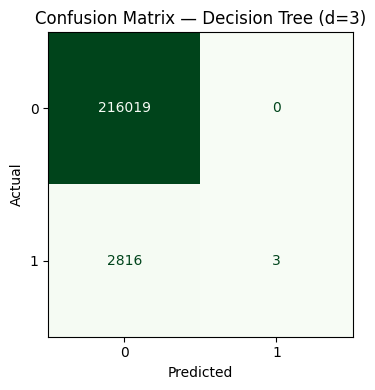

In [30]:
# Confusion matrix — Decision Tree (saves PNG)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_tree = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Greens", colorbar=False, values_format="d")
ax.set_title("Confusion Matrix — Decision Tree (d=3)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.savefig("cm_tree.png", dpi=200)
plt.show()


# Bar chart of top feature importances (saves PNG)
import matplotlib.pyplot as plt

# If you already computed feat_imp above, reuse it; otherwise rebuild quickly:
try:
    feat_imp  # check if exists
except NameError:
    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(input_features=cat_cols)
    num_feature_names = [str(c) for c in num_cols]
    expanded_feature_names = list(cat_feature_names) + num_feature_names
    importances = tree_pipe.named_steps["clf"].feature_importances_
    import pandas as pd
    feat_imp = pd.DataFrame({"feature": expanded_feature_names, "importance": importances}) \
                 .sort_values("importance", ascending=False)

topN = 15
top_imp = feat_imp.head(topN).iloc[::-1]  # reverse for horizontal plot



Markdown cell: Explain decision trees as a simple non-linear model.


## **4. Performance Metrics**


Numeric: ['Vict Age', 'AREA', 'Rpt Dist No', 'occ_month', 'occ_dow', 'occ_hour']
Categorical: ['Vict Sex', 'Vict Descent', 'AREA NAME', 'Premis Desc', 'Weapon Desc', 'time_bin']
=== Logistic Regression (baseline) ===
Accuracy:          0.854
Balanced Accuracy: 0.871
Precision:         0.073
Recall:            0.888
F1 Score:          0.135
ROC-AUC:           0.933
PR-AUC:            0.144

Confusion Matrix (TN, FP; FN, TP):
[[184286  31733]
 [   315   2504]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    216019
           1       0.07      0.89      0.14      2819

    accuracy                           0.85    218838
   macro avg       0.54      0.87      0.53    218838
weighted avg       0.99      0.85      0.91    218838



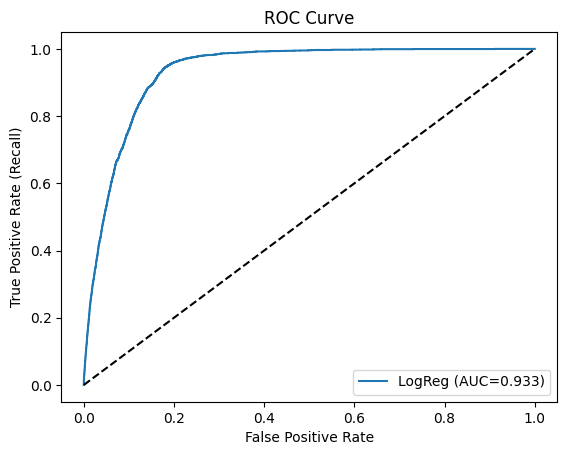

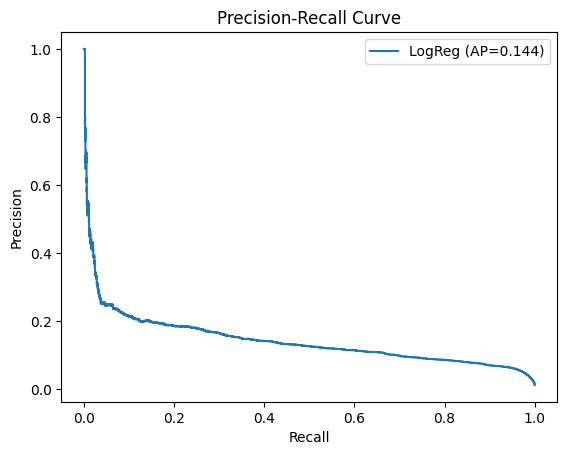

In [31]:
# Code cell: Build and evaluate the LOGISTIC REGRESSION model

# Code cell: Build, evaluate, and plot the LOGISTIC REGRESSION model

# Separate numeric vs categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# Preprocessor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols)
])

# Logistic Regression with class_weight to handle imbalance
logit_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))
])

# Train and predict
logit_pipe.fit(X_train, y_train)
y_pred_logit = logit_pipe.predict(X_test)
y_proba_logit = logit_pipe.predict_proba(X_test)[:, 1]

# Evaluate
acc  = accuracy_score(y_test, y_pred_logit)
bacc = balanced_accuracy_score(y_test, y_pred_logit)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_logit, average="binary", zero_division=0)
roc  = roc_auc_score(y_test, y_proba_logit)
ap   = average_precision_score(y_test, y_proba_logit)

print("=== Logistic Regression (baseline) ===")
print(f"Accuracy:          {acc:.3f}")
print(f"Balanced Accuracy: {bacc:.3f}")
print(f"Precision:         {prec:.3f}")
print(f"Recall:            {rec:.3f}")
print(f"F1 Score:          {f1:.3f}")
print(f"ROC-AUC:           {roc:.3f}")
print(f"PR-AUC:            {ap:.3f}")

print("\nConfusion Matrix (TN, FP; FN, TP):")
print(confusion_matrix(y_test, y_pred_logit))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logit, zero_division=0))

# --- Graphs ---
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_logit)
plt.figure()
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_logit)
plt.figure()
plt.plot(recalls, precisions, label=f"LogReg (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


                     accuracy  balanced_accuracy  precision  recall     f1
Model                                                                     
Majority Class          0.987              0.500      0.000   0.000  0.000
Logistic Regression     0.854              0.871      0.073   0.888  0.135
Decision Tree           0.862              0.880      0.078   0.900  0.144


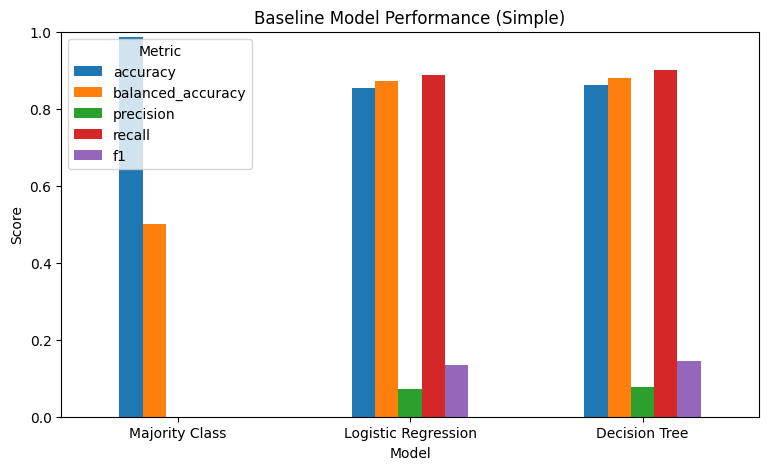

In [26]:
# Code cell: Bar graph comparison of baseline models

# === Simple baselines + metrics + bar chart ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support
)

# 1) Preprocessor (one-hot for categoricals, passthrough numerics)
num_cols = X_train.select_dtypes(include=['number', 'bool']).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols)
])

# 2) Helper to compute a few core metrics
def core_metrics(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return {"accuracy": acc, "balanced_accuracy": bacc,
            "precision": prec, "recall": rec, "f1": f1}

results = []

# 3) Majority class (dummy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
metrics_dummy = core_metrics(y_test, dummy.predict(X_test))
results.append({"Model": "Majority Class", **metrics_dummy})

# 4) Logistic Regression (simple, handles imbalance)
logit = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))
])
logit.fit(X_train, y_train)
metrics_lr = core_metrics(y_test, logit.predict(X_test))
results.append({"Model": "Logistic Regression", **metrics_lr})

# 5) Simple Decision Tree (shallow, handles imbalance)
tree = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(max_depth=4, class_weight="balanced", random_state=42))
])
tree.fit(X_train, y_train)
metrics_tree = core_metrics(y_test, tree.predict(X_test))
results.append({"Model": "Decision Tree", **metrics_tree})

# 6) Table + Bar chart
df_results = pd.DataFrame(results).set_index("Model").round(3)
print(df_results)

ax = df_results.plot(kind="bar", figsize=(9,5))
plt.title("Baseline Model Performance (Simple)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.show()


Markdown cell: Highlight differences across models, discuss class imbalance, compare how the three complement each other.


## **5. Ethical Concerns (Markdown cell only)**


- Underreporting bias.
- Demographic imbalance (sex, race).
- Neighborhood policing bias.
- Risks of relying only on accuracy.


## **6. Mitigation Strategies (Markdown cell only)**


- Class balancing (oversampling/undersampling).
- Group-specific metrics (by sex, race).
- Transparency about missing values and bias.


## **7. Conclusion (Markdown cell only)**


- Summary of baseline performance.
- Roadmap for next sprint: stronger models, fairness analysis.

